In [1]:
import cv2
import h5py
import numpy as np
import scipy as sp
from scipy.misc import imresize
from skimage.color import gray2rgb
from skimage.io import imread
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Model
from keras import backend as K
from keras.applications.vgg16 import VGG16, preprocess_input

/usr/lib/python3.5/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
Using Theano backend.


In [2]:
import re

with h5py.File('data/uhcs.h5', 'r') as hfile:
    keys = list(hfile)
    
m_idx = lambda key: int(re.search(r'\d+', key).group())
mlist = list(map(m_idx, keys))

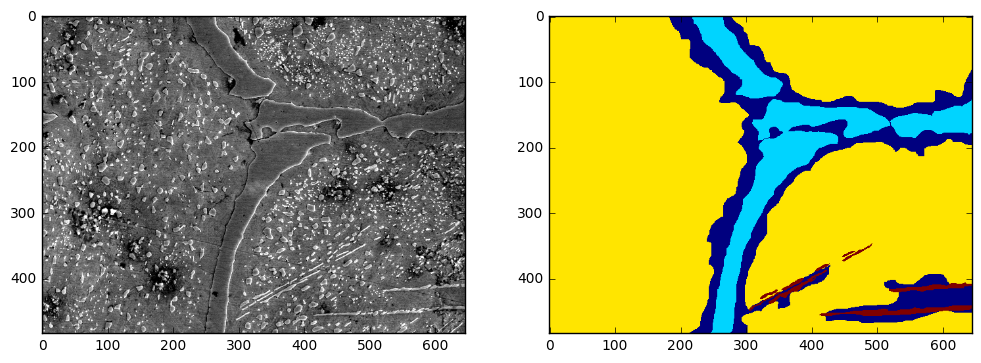

In [7]:
def load_image(hfile, record_id):
    with h5py.File(hfile, 'r') as f:
        g = f['micrograph{}'.format(record_id)]
        im = g['image'][...]
        labels = g['labels'][...]

        return im[:-38], labels[:-38]
    
def load_tif(m_id):
    im = imread('uhcs/micrograph{}.tif'.format(m_id), as_grey=True)
    return im[:-38]

def load_dataset(hfile):
    images, labels = [], []
    with h5py.File(hfile, 'r') as f:
        for key in f:
            micrograph = f[key]
            im = micrograph['image'][...]
            l = micrograph['labels'][...]

            images.append(im[:-38])
            labels.append(l[:-38])
            
    return images, labels

images, labels = load_dataset('data/uhcs.h5')
fig, ax = plt.subplots(1,2, figsize=(12,8))
ax[0].imshow(images[0], cmap=plt.cm.gray)
ax[1].imshow(labels[0])

In [5]:
cnn = VGG16(include_top=False, weights='imagenet')
layer_id = {layer.name: idx for idx, layer in enumerate(cnn.layers)}

def image_tensor(image):
    image3d = gray2rgb(image).astype(np.float32)
    x = 255*image3d.transpose((2,0,1))
    x = np.expand_dims(x, axis=0)
    return preprocess_input(x)

outputs = ['block4_conv3', 'block5_conv3']
layers=('block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3')
model = Model(
    input=cnn.input,
    output=list(map(lambda layer: cnn.get_layer(layer).output, layers))
)

In [17]:
# hypercolumn features with block-wise PCA whitening
# extract multiple feature maps for multiple images
# apply PCA with whitening to each feature map set
# interpolate each reduced feature map onto the target image size
# concatenate feature maps into whitened hypercolumn features
# apply SVM, t-SNE, etc.

n_components = 32

block_pca = {
    layer: PCA(n_components=n_components, whiten=True) 
    for layer in layers
}

# extract featuremaps for multiple images
images = [load_image('annotated-uhcs.h5', key)[0] for key in mlist]
h_target, w_target = images[0].shape

x_in = [image_tensor(im) for im in images]
xx = model.predict(np.vstack(x_in))

hc = []
for feature_idx in range(len(layers)):
    print('block {}'.format(feature_idx))
    # reshape feature map into [feature, channels]
    b, nchan, h, w = xx[feature_idx].shape
    X = xx[feature_idx]
    ff = X.transpose(0,2,3,1) # to [batch, height, width, channels]
    ff = ff.reshape((-1, nchan)) # to [feature, channels]
    
    block = layers[feature_idx]
    if ff.shape[0] > 1e6:
        choice = np.random.choice(ff.shape[0], size=1e6, replace=False)
        block_pca[block].fit(ff[choice])
    else:
        block_pca[block].fit(ff)
    xpca = block_pca[block].transform(ff)

    # reshape reduced feature maps back to image tensor layout
    xxpca = xpca.reshape((b,h,w,n_components)) # to batch, height, width, channels
    xxpca = xxpca.transpose(0,3,1,2) # to batch, channels, height, width
    
    # interpolate each channel onto target size
    # preallocate output
    hc_block = np.zeros((b, n_components, h_target, w_target))
    
    for image_idx in range(b):
        for channel_idx in range(n_components):
            # careful: cv2 swaps image shape order...
            hc_block[image_idx,channel_idx,:,:] = cv2.resize(xxpca[image_idx,channel_idx,:,:], (w_target, h_target))
            
    hc.append(hc_block)
    
hcc = np.concatenate(hc, axis=1)

block 0


/usr/lib/python3.5/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


block 1
block 2
block 3
block 4


In [26]:
# fit SGD-SVM on hc data -- takes a couple seconds for 4 images
# SVM with LibLinear takes quite a while for the same dataset
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='hinge', alpha=0.0001, class_weight='balanced')

# reshape feature map into [feature, channels]
b, nchan, h, w = hcc.shape

ff = hcc.transpose(0,2,3,1) # to [batch, height, width, channels]
ff = ff.reshape((-1, nchan)) # to [feature, channels]
print(ff.shape)
labels = np.array([load_image('annotated-uhcs.h5', key)[1] for key in mlist]).flatten()


# instance normalization: 
ff = ff / np.linalg.norm(ff, axis=1)[:,np.newaxis]
clf.fit(ff, labels)
print('SVM model finished.')

y = clf.predict(ff)
yy = y.reshape((24,h_target, w_target))

(7492320, 160)
SVM model finished.


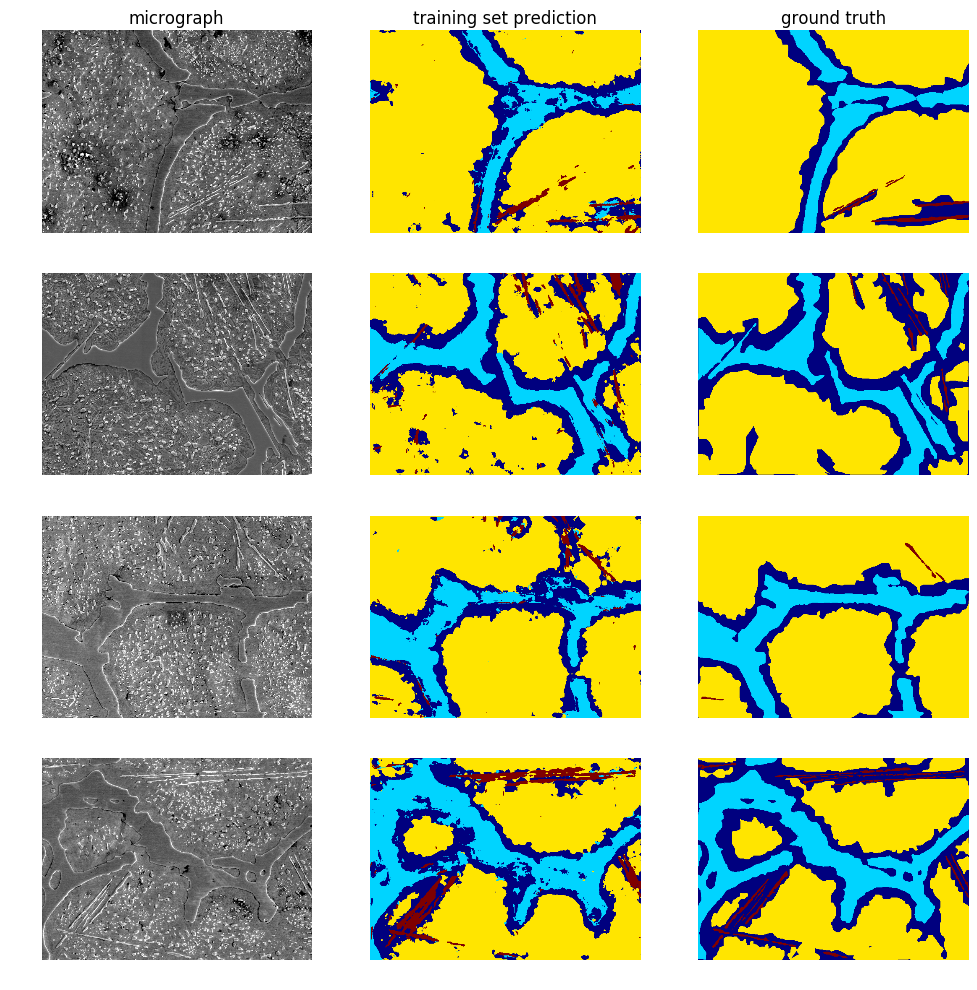

In [54]:
fig, axes = plt.subplots(4,3,figsize=(12,12))
idx = 0
for idx, ax in enumerate(axes):
    if idx == 0:
        for a, title in zip(ax, ('micrograph', 'training set prediction', 'ground truth')):
            a.set_title(title)
    ax[0].imshow(images[idx], cmap=plt.cm.gray)
    ax[1].imshow(yy[idx])
    ax[2].imshow(labels.reshape(24,h_target, w_target)[idx])
    
    for a in ax:
        a.axis('off')

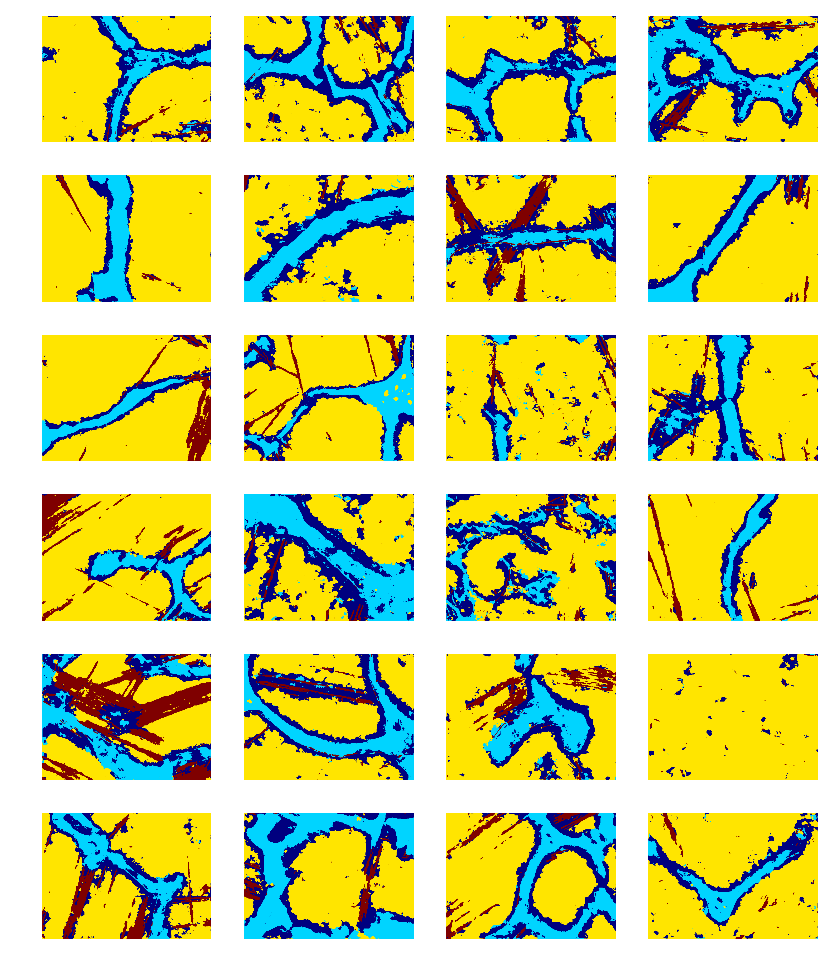

In [46]:
# display all training set predictions
fig, axes = plt.subplots(6,4, figsize=(10,12))
for idx, ax in enumerate(axes.flat):
    ax.imshow(yy[idx])
    # ax.imshow(images[idx], cmap=plt.cm.gray)
    # ax.imshow(labels.reshape(24,h_target, w_target)[idx])
    ax.axis('off')

In [29]:
# apply model to test images.... which don't have annotations yet.

# test = [1061, 1249, 596, 643]

test = [1232, 1356, 1411, 710]

# hypercolumn features with block-wise PCA whitening
# extract multiple feature maps for multiple images
# apply PCA with whitening to each feature map set
# interpolate each reduced feature map onto the target image size
# concatenate feature maps into whitened hypercolumn features
# apply SVM, t-SNE, etc.


# extract featuremaps for multiple images
t_images = [load_tif(key) for key in test]
h_target, w_target = images[0].shape

t_x_in = [image_tensor(im) for im in t_images]
t_xx = model.predict(np.vstack(t_x_in))

hc = []
for feature_idx in range(len(layers)):
    print('block {}'.format(feature_idx))
    # reshape feature map into [feature, channels]
    b, nchan, h, w = t_xx[feature_idx].shape
    X = t_xx[feature_idx]
    ff = X.transpose(0,2,3,1) # to [batch, height, width, channels]
    ff = ff.reshape((-1, nchan)) # to [feature, channels]
    
    block = layers[feature_idx]
    # block_pca[block].fit(ff)
    xpca = block_pca[block].transform(ff)

    # reshape reduced feature maps back to image tensor layout
    xxpca = xpca.reshape((b,h,w,n_components)) # to batch, height, width, channels
    xxpca = xxpca.transpose(0,3,1,2) # to batch, channels, height, width
    
    # interpolate each channel onto target size
    # preallocate output
    hc_block = np.zeros((b, n_components, h_target, w_target))
    
    for image_idx in range(b):
        for channel_idx in range(n_components):
            # careful: cv2 swaps image shape order...
            hc_block[image_idx,channel_idx,:,:] = cv2.resize(xxpca[image_idx,channel_idx,:,:], (w_target, h_target))
            
    hc.append(hc_block)
    
t_hcc = np.concatenate(hc, axis=1)

/usr/lib/python3.5/site-packages/skimage/external/tifffile/tifffile_local.py:1394: UserWarning: tags are not ordered by code
  warnings.warn("tags are not ordered by code")


block 0
block 1
block 2
block 3
block 4


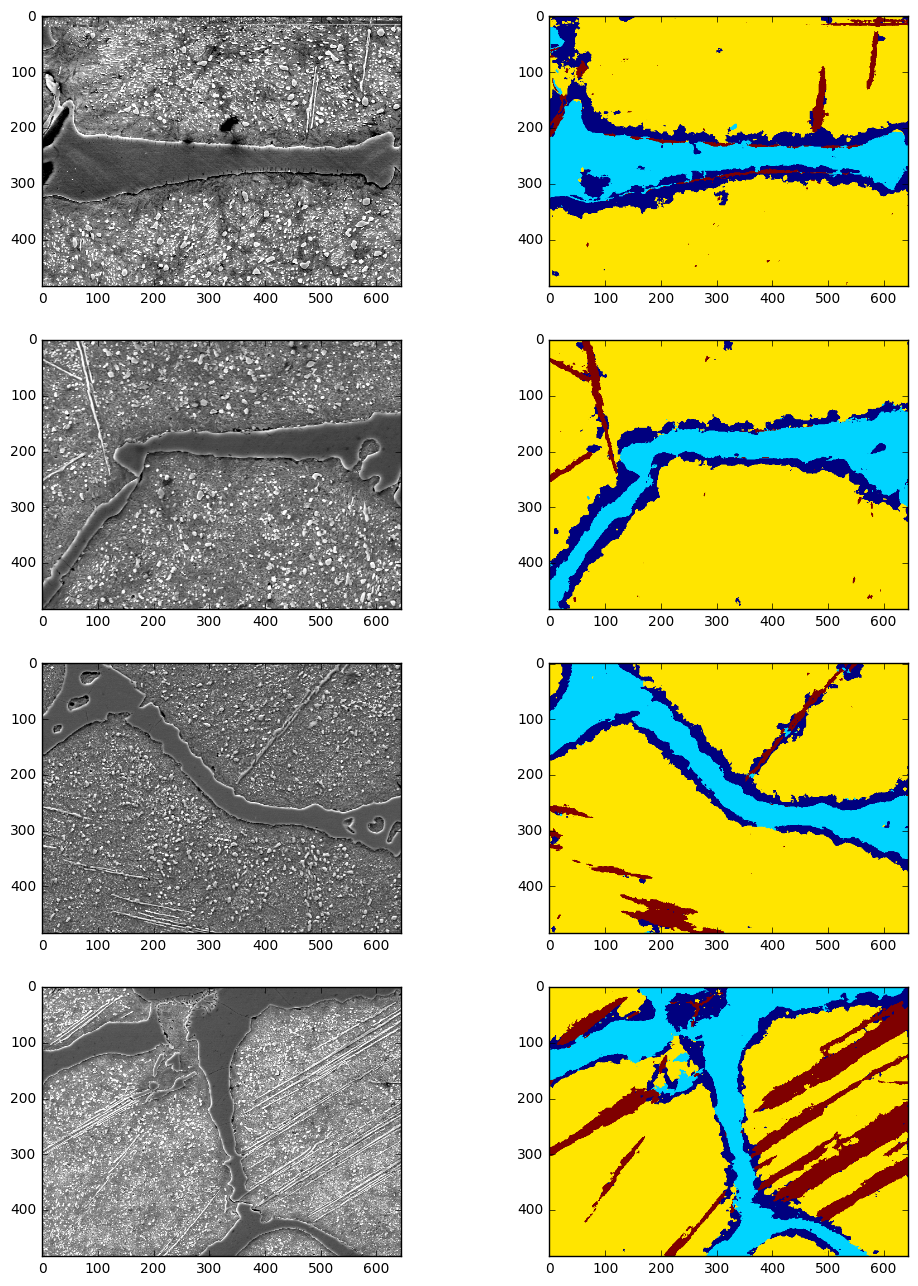

In [36]:
b, nchan, h, w = hcc.shape
ff = t_hcc.transpose(0,2,3,1) # to [batch, height, width, channels]
ff = ff.reshape((-1, nchan)) # to [feature, channels]

# instance normalization
ff = ff / np.linalg.norm(ff, axis=1)[:,np.newaxis]

t_y = clf.predict(ff)
t_yy = t_y.reshape((4,h_target, w_target))

fig, axes = plt.subplots(4,2,figsize=(12,16))
idx = 0
for idx, ax in enumerate(axes):
    ax[0].imshow(t_images[idx], cmap=plt.cm.gray)
    ax[1].imshow(t_yy[idx])

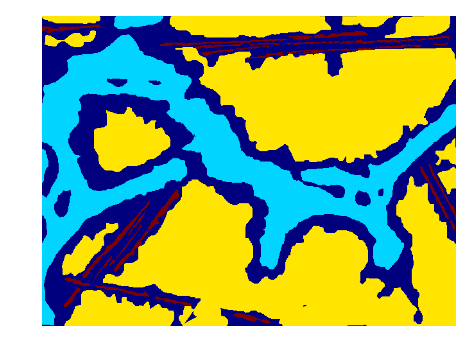

In [12]:
with h5py.File('data/uhcs.h5', 'r') as f:
    l = f['micrograph1219/labels'][...]
    l = l[:-38]
    
plt.imshow(l)
plt.axis('off')
plt.savefig('example_labels.png')